# Application of Linear Regression on SARS-CoV-2 concentrations measured in NYC Wastewater

#### Dylan K. Picart

### Objective 

Using a json dataset that contains insightful health metrics, build an API, extract and format data in a database and table, and build a machine learning model that predicts the future trends of COVID-19 in NYC.

### Sourcing Data
I will be using a Dataset from NYC OpenData to predict future covid wastewater trends and examine how they relate to case rates. This data is from the Department of Health and Mental Hygiene (DOHMH) in New York City.

Source: 
https://data.cityofnewyork.us/Health/SARS-CoV-2-concentrations-measured-in-NYC-Wastewat/f7dc-2q9f

#### Context
The analysis of this project covered the time period of 2020 - 2021. Data is updated on a monthly basis. Results of sampling to determine the SARS-CoV-2 N gene levels in NYC DEP Wastewater Resource Recovery Facility (WRRF) influent, disaggregated by the WRRF where the sample was collected, date sample was collected, and date sample was tested. This data contains sampling from multiple locations throughout NYC, and are appropriately labelled.

**Important Note:** Covid concentrations in wastewater are not the same as Covid Case Rates, and should be treated as seperate. In this project, I explore the commonalities between the infectious cases reported on media to the amount of gene levels prevalent in the wastewater. RT-qPCR was changed to digital PCR in April of 2023, resulting values are about 10-20 times higher than those of RT-qPCR. Please refer to the supporting documentation for more technical information.


##### Useful Libraries

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sqlite3
import json
import sqlalchemy
from sqlalchemy import create_engine, select, MetaData, Table, and_
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.inspection import inspect
from sklearn.linear_model import SGDRegressor

## API Access & Building

First, we will establish our API connection to source the data.

In [ ]:
r = requests.get('https://data.cityofnewyork.us/resource/f7dc-2q9f.json')
r.json()

[{'sample_date': '2020-08-31T00:00:00.000',
  'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': '26th Ward',
  'wrrf_abbreviation': '26W',
  'copies_l': '9860',
  'copies_l_x_average_flowrate': '6680000',
  'annotation': 'Concentration below Method Limit of Quantification (above Method Limit of Detection);This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)',
  'population_served': '290608'},
 {'sample_date': '2020-08-31T00:00:00.000',
  'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': 'Bowery Bay',
  'wrrf_abbreviation': 'BB',
  'copies_l': '30500',
  'copies_l_x_average_flowrate': '11200000',
  'annotation': 'This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)',
  'population_served': '924695'},
 {'sample_date': '2020-08-31T00:00:00.000',
  'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': 'Coney Island',
  'wrrf_abbrevia

We will be creating a DataBase with this API in order to acces, clean, and apply our data for regression analysis.

In [ ]:
# To place into a database, let's use list comprehension to convert each row in the r.json() to a string and then tuplefy each row

list_of_tuples = [(json.dumps(row),) for row in r.json()]
list_of_tuples

[('{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "26th Ward", "wrrf_abbreviation": "26W", "copies_l": "9860", "copies_l_x_average_flowrate": "6680000", "annotation": "Concentration below Method Limit of Quantification (above Method Limit of Detection);This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)", "population_served": "290608"}',),
 ('{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "Bowery Bay", "wrrf_abbreviation": "BB", "copies_l": "30500", "copies_l_x_average_flowrate": "11200000", "annotation": "This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)", "population_served": "924695"}',),
 ('{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "Coney Island", "wrrf_abbreviation": "CI", "copies_l

We will use SQLite to begin our Database creation and subsequent manipulation.

In [ ]:
# Let's establish our connection and create a database
con = sqlite3.connect('covid_conc_samples.db')
# Create a cursor to navigate the database & perform actions
cur = con.cursor()

In [ ]:
# Let's create a table to store the raw data

sql_create_raw_json_table = '''CREATE TABLE raw_json(
                                id INTEGER PRIMARY KEY AUTOINCREMENT,
                                raw_text text
                            )'''

# Execute the creation of the table
cur.execute(sql_create_raw_json_table)
# Insert the list of tuples into the table
cur.executemany('INSERT INTO raw_json (raw_text) VALUES (?)', list_of_tuples)
# Finalize your changes
con.commit()

In [ ]:
# Let's check by executing a command
cur.execute('SELECT * FROM raw_json')
# Fetch all the values from our cur.execute
x = cur.fetchall()
# Print list of values in for every row in x
[row for row in x]

[(1,
  '{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "26th Ward", "wrrf_abbreviation": "26W", "copies_l": "9860", "copies_l_x_average_flowrate": "6680000", "annotation": "Concentration below Method Limit of Quantification (above Method Limit of Detection);This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)", "population_served": "290608"}'),
 (2,
  '{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "Bowery Bay", "wrrf_abbreviation": "BB", "copies_l": "30500", "copies_l_x_average_flowrate": "11200000", "annotation": "This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)", "population_served": "924695"}'),
 (3,
  '{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "Coney Island", "wrrf_abbreviation": "C

In [ ]:
# Let's further build out this API to easily access & extract our raw data

def get_raw_data():
    con = sqlite3.connect('covid_conc_samples.db')
    cur = con.cursor()
    list_of_rows = [row for row in cur.execute('SELECT * from raw_json')]
    con.close()
    return list_of_rows

raw_data = get_raw_data()

raw_data

[(1,
  '{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "26th Ward", "wrrf_abbreviation": "26W", "copies_l": "9860", "copies_l_x_average_flowrate": "6680000", "annotation": "Concentration below Method Limit of Quantification (above Method Limit of Detection);This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)", "population_served": "290608"}'),
 (2,
  '{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "Bowery Bay", "wrrf_abbreviation": "BB", "copies_l": "30500", "copies_l_x_average_flowrate": "11200000", "annotation": "This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)", "population_served": "924695"}'),
 (3,
  '{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "Coney Island", "wrrf_abbreviation": "C

In [ ]:
row_id, row_text = x[0]

row_id, row_text

(1,
 '{"sample_date": "2020-08-31T00:00:00.000", "test_date": "2020-09-01T00:00:00.000", "wrrf_name": "26th Ward", "wrrf_abbreviation": "26W", "copies_l": "9860", "copies_l_x_average_flowrate": "6680000", "annotation": "Concentration below Method Limit of Quantification (above Method Limit of Detection);This concentration was obtained using a pooled standard curve (pooled from RT-qPCR plates run between 9/11/2020 and 4/14/2021)", "population_served": "290608"}')

In [ ]:
# Convert back to dictionary
row_text = json.loads(row_text)
row_text.keys()

dict_keys(['sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served'])

In [ ]:
# Let's create a workable data table where we use the key-values we care about

kvs_for_work_table = ['sample_date', 'test_date', 'wrrf_name', 'copies_l',
                      'copies_l_x_average_flowrate', 'population_served']

In [ ]:
def data_extractor(list_of_tuples, list_of_keys):
    # Create empty list to store unpacked dictionaries
    list_of_relevant_info = []
    # Extract json from tuple pair by unpacking
    # x: id, y: {raw_json}
    for x, y in list_of_tuples:
        # Set up a temporary dictionary to hold pruned k-v pairs- it's reset on every iterative loop
        temp_dict = {}
        # We need to jsonify our string
        parsed_json = json.loads(y)
        # Iterate over the key-value pairings in our dictionary
        # Unpack the JSON, storing keys in k, values in v
        # Only want to retain the key-values I care about
        for k, v in parsed_json.items():
            # Check if it matches the string in the kvs_i_care_about
            if k in list_of_keys:
                # If it matches, store the key-value pairing
                temp_dict[k] = v
            # Append to the list & do this for every k-v pairings that match
        list_of_relevant_info.append(temp_dict)
    return list_of_relevant_info

In [ ]:
y = data_extractor(raw_data, row_text.keys())

In [ ]:
kvs_to_delete = ['sample_date', 'wrrf_abbreviation', 'annotation']

In [ ]:
def column_deleter(list_of_dicts, kvs_to_get_rid_of):
    cleaned_dicts = []
    for row in list_of_dicts:
        temp_dict = {}
        for key in row.keys():
            if key in kvs_to_get_rid_of:
                pass
            else:
                temp_dict[key] = row[key]
        cleaned_dicts.append(temp_dict)
    return cleaned_dicts

workable_lod = column_deleter(y, kvs_to_delete)
workable_lod

[{'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': '26th Ward',
  'copies_l': '9860',
  'copies_l_x_average_flowrate': '6680000',
  'population_served': '290608'},
 {'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': 'Bowery Bay',
  'copies_l': '30500',
  'copies_l_x_average_flowrate': '11200000',
  'population_served': '924695'},
 {'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': 'Coney Island',
  'copies_l': '7700',
  'copies_l_x_average_flowrate': '4270000',
  'population_served': '682342'},
 {'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': 'Hunts Point',
  'copies_l': '23800',
  'copies_l_x_average_flowrate': '14600000',
  'population_served': '755948'},
 {'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': 'Jamaica Bay',
  'copies_l': '16000',
  'copies_l_x_average_flowrate': '5910000',
  'population_served': '748737'},
 {'test_date': '2020-09-01T00:00:00.000',
  'wrrf_name': 'Newtown Creek',
  'copies_l': '4990',
  'copies_l_x_average_flowrate': '3100000

In [ ]:
keys_I_care_about = [x for x  in row_text.keys()]
# Delete keys I care about
# Iterate through the list of tuples
def data_converter(json_data, kv_pairs_to_make):
    list_of_tup_dicts = []

    for row in x:
        a,b = row
        # Tuple unpack

        b = json.loads(b)
        # Take the string and make it into a dictionary

        temp_dict = {}


        for key in keys_I_care_about:

            if key in b.keys():
                temp_dict[key] = b[key]
            else:
                temp_dict[key]='NaN'
        # Tuplefy
        tuple_to_add = tuple(x for x in temp_dict.values())
        # Append tuplefied elements to list of dictionaries
        list_of_tup_dicts.append(tuple_to_add)
    return list_of_tup_dicts

In [ ]:
list_of_tup_dicts

Let's create our table we will use to modify our data.

In [ ]:
sql_to_create_work_data = ''' CREATE TABLE work_data(
                            id INTEGER PRIMARY KEY AUTOINCREMENT,
                            sample_date TEXT,
                            test_date TEXT,
                            wrrf_name TEXT,
                            wrrf_abbreviation TEXT,
                            copies_l INTEGER,
                            copies_l_x_average_flowrate INTEGER,
                            annotation TEXT,
                            population_served INTEGER)'''

cur.execute(sql_to_create_work_data)

In [ ]:
cur.executemany('INSERT INTO work_data (sample_date, test_date, wrrf_name, wrrf_abbreviation, copies_l, copies_l_x_average_flowrate, annotation, population_served) VALUES (?, ?, ?, ?, ?, ?, ?, ?)', list_of_tup_dicts)

In [ ]:
con.commit()

## Helper Functions

Next let's create some helper functions so access the table in Python

In [ ]:
# Let's delete the NaN values
cur.execute('DELETE FROM work_data WHERE copies_l = ?', ('NaN',))

In [ ]:
con.commit()

In [ ]:
# Drop columns from work_data table
cur.executemany('ALTER TABLE work_data DROP ?, ?, ?', ('sample_date', 'annotation', 'wrrf_abbreviation',))

OperationalError: near "?": syntax error

In [ ]:
# This is how our original work table looks

def work_table():
    cur.execute('SELECT * FROM work_data')
    return cur.fetchall()

work_data = pd.DataFrame(work_table())
work_data.columns = ['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served']

work_data

,id,sample_date,test_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,annotation,population_served
0,1,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,26th Ward,26W,9860,6680000.0,Concentration below Method Limit of Quantifica...,290608
1,2,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Bowery Bay,BB,30500,11200000.0,This concentration was obtained using a pooled...,924695
2,3,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Coney Island,CI,7700,4270000.0,Concentration below Method Limit of Quantifica...,682342
3,4,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Hunts Point,HP,23800,14600000.0,This concentration was obtained using a pooled...,755948
4,5,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Jamaica Bay,JA,16000,5910000.0,This concentration was obtained using a pooled...,748737
...,...,...,...,...,...,...,...,...,...
914,994,2021-06-15T00:00:00.000,2021-06-16T00:00:00.000,Wards Island,WI,29000,15700000.0,This concentration was obtained using a pooled...,1201485
915,995,2021-06-20T00:00:00.000,2021-06-21T00:00:00.000,26th Ward,26W,21000,13400000.0,This concentration was obtained using a pooled...,290608
916,996,2021-06-20T00:00:00.000,2021-06-21T00:00:00.000,Bowery Bay,BB,22500,8020000.0,This concentration was obtained using a pooled...,924695
917,998,2021-06-20T00:00:00.000,2021-06-21T00:00:00.000,Hunts Point,HP,15800,10500000.0,this sample was analyzed in duplicate. The hig...,755948


In [ ]:
cur.execute('SELECT * FROM work_data WHERE copies_l = ?', ('NaN',))
pd.DataFrame(cur.fetchall())

""


Here we can see that there are 81 NaN values, typically due to the concentration being below the limit of detection. Other reasons include analytical errors. While it unwise to not include NaN values for it being too small for measurable methods to detect, for the sake of simplification we will focus on the measured values to make our analysis

In [ ]:
# To ensure copies_l_avgflowrate NaN values in the same rows as copies_l
cur.execute('SELECT * FROM work_data WHERE copies_l_x_average_flowrate = ?', ('NaN',))
pd.DataFrame(cur.fetchall())

""


In [ ]:
'''
# DID NOT WORK - CANNOT DO MUCH WITH ALTER TABLE ON SQLite

# Change the date format from TEXT to DATE
cur.execute('ALTER TABLE work_data ALTER COLUMN test_date DATE')
'''

In [ ]:
def select_by_abv_loc(wrrf_abrv):
    cur.execute("SELECT * FROM work_data WHERE wrrf_abbreviation = ?", (wrrf_abrv,))
    return cur.fetchall()

In [ ]:
'''
This is an alternative way

def select_by_abv_loc(wrrf_abrv):
    cur.execute("SELECT * FROM work_data WHERE wrrf_abbreviation=:x", {'x': wrrf_abrv})
    return cur.fetchall()

ci = pd.DataFrame(select_by_abv_loc('CI'))
ci.set_axis(['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served'], axis=1, inplace=True)
'''

In [ ]:
def select_by_test_month(start, end):
    cur.execute("SELECT * FROM work_data WHERE test_date BETWEEN ? AND ?", (start, end))
    return cur.fetchall()

In [ ]:
# Create our DataFrames containing the data from September to June

sep = pd.DataFrame(select_by_test_month('2020-09-01T00:00:00.000', '2020-10-01T00:00:00.000'))
okt = pd.DataFrame(select_by_test_month('2020-10-01T00:00:00.000', '2020-11-01T00:00:00.000'))
nov = pd.DataFrame(select_by_test_month('2020-11-01T00:00:00.000', '2020-12-01T00:00:00.000'))
dec = pd.DataFrame(select_by_test_month('2020-12-01T00:00:00.000', '2021-01-01T00:00:00.000'))
jan = pd.DataFrame(select_by_test_month('2021-01-01T00:00:00.000', '2021-02-01T00:00:00.000'))
feb = pd.DataFrame(select_by_test_month('2021-02-01T00:00:00.000', '2021-03-01T00:00:00.000'))
mar = pd.DataFrame(select_by_test_month('2021-03-01T00:00:00.000', '2021-04-01T00:00:00.000'))
apr = pd.DataFrame(select_by_test_month('2021-04-01T00:00:00.000', '2021-05-01T00:00:00.000'))
may = pd.DataFrame(select_by_test_month('2021-05-01T00:00:00.000', '2021-06-01T00:00:00.000'))
jun = pd.DataFrame(select_by_test_month('2021-06-01T00:00:00.000', '2021-07-01T00:00:00.000'))

jun

,0,1,2,3,4,5,6,7,8
0,925,2021-06-01T00:00:00.000,2021-06-02T00:00:00.000,26th Ward,26W,27900,16400000.0,This concentration was obtained using a pooled...,290608
1,926,2021-06-01T00:00:00.000,2021-06-02T00:00:00.000,Bowery Bay,BB,18400,6640000.0,This concentration was obtained using a pooled...,924695
2,927,2021-06-01T00:00:00.000,2021-06-02T00:00:00.000,Coney Island,CI,15600,5890000.0,This concentration was obtained using a pooled...,682342
3,928,2021-06-01T00:00:00.000,2021-06-02T00:00:00.000,Hunts Point,HP,8680,5080000.0,Concentration below Method Limit of Quantifica...,755948
4,930,2021-06-01T00:00:00.000,2021-06-02T00:00:00.000,Newtown Creek,NC,7550,4130000.0,Concentration below Method Limit of Quantifica...,1156473
...,...,...,...,...,...,...,...,...,...
64,994,2021-06-15T00:00:00.000,2021-06-16T00:00:00.000,Wards Island,WI,29000,15700000.0,This concentration was obtained using a pooled...,1201485
65,995,2021-06-20T00:00:00.000,2021-06-21T00:00:00.000,26th Ward,26W,21000,13400000.0,This concentration was obtained using a pooled...,290608
66,996,2021-06-20T00:00:00.000,2021-06-21T00:00:00.000,Bowery Bay,BB,22500,8020000.0,This concentration was obtained using a pooled...,924695
67,998,2021-06-20T00:00:00.000,2021-06-21T00:00:00.000,Hunts Point,HP,15800,10500000.0,this sample was analyzed in duplicate. The hig...,755948


In [ ]:
# Efficient way to store month dataframes in variables
'''
# DID NOT FINISH
months = [sep, oct, nov, dec, jan, feb, mar, apr, may, jun]

for month in months:
    month = pd.DataFrame(select_by_test_month(start, end))

'''

In [ ]:
# Helper function to select a specific location by month
def select_loc_and_mo(abv, start, end):
    cur.execute('SELECT * FROM work_data WHERE wrrf_abbreviation = ? AND test_date BETWEEN ? AND ?', (abv, start, end,))
    return cur.fetchall()

In [ ]:
# We have 14 locations - let's do this for each

w26 = pd.DataFrame(select_by_abv_loc('26W'))
bb = pd.DataFrame(select_by_abv_loc('BB'))
ci = pd.DataFrame(select_by_abv_loc('CI'))
hp = pd.DataFrame(select_by_abv_loc('HP'))
ja = pd.DataFrame(select_by_abv_loc('JA'))
nc = pd.DataFrame(select_by_abv_loc('NC'))
nr = pd.DataFrame(select_by_abv_loc('NR'))
ob = pd.DataFrame(select_by_abv_loc('OB'))
oh = pd.DataFrame(select_by_abv_loc('OH'))
pr = pd.DataFrame(select_by_abv_loc('PR'))
rh = pd.DataFrame(select_by_abv_loc('RH'))
rk = pd.DataFrame(select_by_abv_loc('RK'))
ti = pd.DataFrame(select_by_abv_loc('TI'))
wi = pd.DataFrame(select_by_abv_loc('WI'))

dfs = [w26, bb, ci, hp, ja, nc, nr, ob, oh, pr, rh, rk, ti, wi]

for df in dfs:
    df.columns = ['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served']

    # df = df[(df.copies_l != 'NaN') & (df.copies_l_x_average_flowrate != 'NaN')] - DID NOT WORK

bb


,id,sample_date,test_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,annotation,population_served
0,2,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Bowery Bay,BB,30500,11200000,This concentration was obtained using a pooled...,924695
1,44,2020-09-08T00:00:00.000,2020-09-09T00:00:00.000,Bowery Bay,BB,24100,8190000,This concentration was obtained using a pooled...,924695
2,58,2020-09-13T00:00:00.000,2020-09-14T00:00:00.000,Bowery Bay,BB,32400,11900000,This concentration was obtained using a pooled...,924695
3,72,2020-09-15T00:00:00.000,2020-09-16T00:00:00.000,Bowery Bay,BB,24600,8670000,This concentration was obtained using a pooled...,924695
4,86,2020-09-20T00:00:00.000,2020-09-21T00:00:00.000,Bowery Bay,BB,36100,13600000,This concentration was obtained using a pooled...,924695
...,...,...,...,...,...,...,...,...,...
61,940,2021-06-06T00:00:00.000,2021-06-07T00:00:00.000,Bowery Bay,BB,15600,5880000,This concentration was obtained using a pooled...,924695
62,954,2021-06-08T00:00:00.000,2021-06-09T00:00:00.000,Bowery Bay,BB,58200,33100000,This concentration was obtained using a pooled...,924695
63,968,2021-06-13T00:00:00.000,2021-06-14T00:00:00.000,Bowery Bay,BB,11200,3900000,Concentration below Method Limit of Quantifica...,924695
64,982,2021-06-15T00:00:00.000,2021-06-16T00:00:00.000,Bowery Bay,BB,24400,8600000,This concentration was obtained using a pooled...,924695


In [ ]:
''' # DID NOT WORK
# Efficient way to make multiple Location DataFrames, rename the columns, & drop all of the NaN values


dfs = [w26, bb, ci, hp, ja, nc, nr, ob, oh, pr, rh, rk, ti, wi]
abbrv = ['26W', 'BB', 'CI', 'HP', 'JA', 'NC', 'NR', 'OB', 'OH', 'PR', 'RH', 'RK', 'TI', 'WI']
names = []

for df in dfs:
    for ab in abrv:
        df = pd.DataFrame(select_by_abv_loc(ab))
        df.columns = ['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation',
                      'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served']
    # Original way to try to drop NaN - also DID NOT WORK
    df = df[(df.copies_l != 'NaN') & (df.copies_l_x_average_flowrate != 'NaN')]
'''

In [ ]:
# We have 14 locations - let's do this for each

w26 = pd.DataFrame(select_by_abv_loc('26W'))
bb = pd.DataFrame(select_by_abv_loc('BB'))
ci = pd.DataFrame(select_by_abv_loc('CI'))
hp = pd.DataFrame(select_by_abv_loc('HP'))
ja = pd.DataFrame(select_by_abv_loc('JA'))
nc = pd.DataFrame(select_by_abv_loc('NC'))
nr = pd.DataFrame(select_by_abv_loc('NR'))
ob = pd.DataFrame(select_by_abv_loc('OB'))
oh = pd.DataFrame(select_by_abv_loc('OH'))
pr = pd.DataFrame(select_by_abv_loc('PR'))
rh = pd.DataFrame(select_by_abv_loc('RH'))
rk = pd.DataFrame(select_by_abv_loc('RK'))
ti = pd.DataFrame(select_by_abv_loc('TI'))
wi = pd.DataFrame(select_by_abv_loc('WI'))

dfs = [w26, bb, ci, hp, ja, nc, nr, ob, oh, pr, rh, rk, ti, wi]

for df in dfs:
    df.columns = ['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served']
    #df = df[(df.copies_l != 'NaN') & (df.copies_l_x_average_flowrate != 'NaN')] - DNW

bb


,id,sample_date,test_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,annotation,population_served
0,2,2020-08-31T00:00:00.000,2020-09-01T00:00:00.000,Bowery Bay,BB,30500,11200000,This concentration was obtained using a pooled...,924695
1,44,2020-09-08T00:00:00.000,2020-09-09T00:00:00.000,Bowery Bay,BB,24100,8190000,This concentration was obtained using a pooled...,924695
2,58,2020-09-13T00:00:00.000,2020-09-14T00:00:00.000,Bowery Bay,BB,32400,11900000,This concentration was obtained using a pooled...,924695
3,72,2020-09-15T00:00:00.000,2020-09-16T00:00:00.000,Bowery Bay,BB,24600,8670000,This concentration was obtained using a pooled...,924695
4,86,2020-09-20T00:00:00.000,2020-09-21T00:00:00.000,Bowery Bay,BB,36100,13600000,This concentration was obtained using a pooled...,924695
...,...,...,...,...,...,...,...,...,...
61,940,2021-06-06T00:00:00.000,2021-06-07T00:00:00.000,Bowery Bay,BB,15600,5880000,This concentration was obtained using a pooled...,924695
62,954,2021-06-08T00:00:00.000,2021-06-09T00:00:00.000,Bowery Bay,BB,58200,33100000,This concentration was obtained using a pooled...,924695
63,968,2021-06-13T00:00:00.000,2021-06-14T00:00:00.000,Bowery Bay,BB,11200,3900000,Concentration below Method Limit of Quantifica...,924695
64,982,2021-06-15T00:00:00.000,2021-06-16T00:00:00.000,Bowery Bay,BB,24400,8600000,This concentration was obtained using a pooled...,924695


## Hypothesis
---
During the height of the COVID-19 pandemic in New York City, we had skyrocketing cases of COVID-19 infections during the winter months, and diminishing cases as we got closer to spring and summertime. While covid case diagnoses are not the same as covid concentrations in wastewater, there is more than likely a correlation between rising cases and the amount of genetic material prevalent in wastewater. As covid cases rose, so would the concentrations of SARS-COV-2 detected in wastewater.

To test our hypothesis, we will run Data Visualizations across all areas tested & build a Linear Regression Model to predict the trend of subsequent genetic concentrations in wastewater.

### Visualizations for our 14 locations

Let's see what the genetic data looks like through the months of September 2020 - June 2021

In [ ]:
font1 = {'family':'serif','color':'navy','size':13}
font2 = {'family':'serif','color':'darkred','size':12}

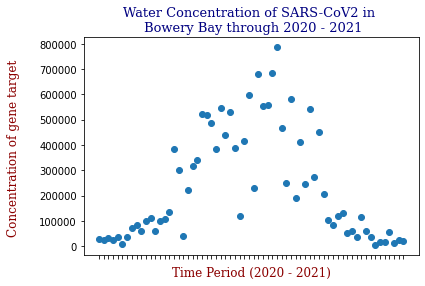

In [ ]:
# Let's see what a scatter looks like
def bb_graph():
    plt.scatter(bb.test_date, bb.copies_l)
    plt.title("Water Concentration of SARS-CoV2 in \n Bowery Bay through 2020 - 2021", fontdict=font1)
    plt.xlabel('Time Period (2020 - 2021)', fontdict=font2), plt.ylabel('Concentration of gene target \n', fontdict=font2)
    ax = plt.gca()
    # Remove ticks & tick labels
    # ax.axes.xaxis.set_ticks([]) (depreciated method - play around with this)
    ax.axes.xaxis.set_ticklabels([])

    plt.show()

bb_graph()

In [ ]:
    curCopData = []


    curCopData.append(curlocData['copies_l'])


In [ ]:
months = [sep, okt, nov, dec, jan, feb, mar, apr, may, jun]


In [ ]:
# Get distinct values of abbreviation column, do it automatically
locs = list(work_data.wrrf_abbreviation.unique())
# Set an empty dictionary called masterData
master_Data = {}

# Iterate through the list of locations in the DF
for loc in locs:
    # Store the Data of each respective location in the variable curlocData
    cur_loc_Data = work_data[work_data["wrrf_abbreviation"].str.contains(loc)]
    # Set each abbreviation as a key, with all of the Data related to it as a value
    master_Data[loc] = cur_loc_Data

master_Data

{'26W':       id              sample_date                test_date  wrrf_name  \
 0      1  2020-08-31T00:00:00.000  2020-09-01T00:00:00.000  26th Ward   
 11    29  2020-09-06T00:00:00.000  2020-09-07T00:00:00.000  26th Ward   
 17    43  2020-09-08T00:00:00.000  2020-09-09T00:00:00.000  26th Ward   
 38    71  2020-09-15T00:00:00.000  2020-09-16T00:00:00.000  26th Ward   
 51    85  2020-09-20T00:00:00.000  2020-09-21T00:00:00.000  26th Ward   
 ..   ...                      ...                      ...        ...   
 862  939  2021-06-06T00:00:00.000  2021-06-07T00:00:00.000  26th Ward   
 875  953  2021-06-08T00:00:00.000  2021-06-09T00:00:00.000  26th Ward   
 887  967  2021-06-13T00:00:00.000  2021-06-14T00:00:00.000  26th Ward   
 901  981  2021-06-15T00:00:00.000  2021-06-16T00:00:00.000  26th Ward   
 915  995  2021-06-20T00:00:00.000  2021-06-21T00:00:00.000  26th Ward   
 
     wrrf_abbreviation  copies_l  copies_l_x_average_flowrate  \
 0                 26W      9860      

In [ ]:
cur_loc_Data

,id,sample_date,test_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,annotation,population_served
26,52,2020-09-08T00:00:00.000,2020-09-09T00:00:00.000,Port Richmond,PR,26800,9790000.0,This concentration was obtained using a pooled...,226167
47,80,2020-09-15T00:00:00.000,2020-09-16T00:00:00.000,Port Richmond,PR,6250,2430000.0,Concentration below Method Limit of Quantifica...,226167
60,94,2020-09-20T00:00:00.000,2020-09-21T00:00:00.000,Port Richmond,PR,21500,7890000.0,This concentration was obtained using a pooled...,226167
81,122,2020-09-27T00:00:00.000,2020-09-28T00:00:00.000,Port Richmond,PR,43500,16700000.0,This concentration was obtained using a pooled...,226167
93,164,2020-10-06T00:00:00.000,2020-10-07T00:00:00.000,Port Richmond,PR,35600,13300000.0,This concentration was obtained using a pooled...,226167
...,...,...,...,...,...,...,...,...,...
858,934,2021-06-01T00:00:00.000,2021-06-02T00:00:00.000,Port Richmond,PR,5340,2320000.0,Concentration below Method Limit of Quantifica...,226167
871,948,2021-06-06T00:00:00.000,2021-06-07T00:00:00.000,Port Richmond,PR,27800,18600000.0,This concentration was obtained using a pooled...,226167
883,962,2021-06-08T00:00:00.000,2021-06-09T00:00:00.000,Port Richmond,PR,15100,13100000.0,This concentration was obtained using a pooled...,226167
896,976,2021-06-13T00:00:00.000,2021-06-14T00:00:00.000,Port Richmond,PR,49700,22500000.0,This concentration was obtained using a pooled...,226167


In [ ]:
list(cur_loc_Data['copies_l'])

[26800,
 6250,
 21500,
 43500,
 35600,
 37700,
 50800,
 31100,
 96000,
 61300,
 116000,
 71000,
 215000,
 320000,
 413000,
 42600,
 172000,
 309000,
 429000,
 362000,
 753000,
 593000,
 918000,
 575000,
 418000,
 630000,
 249000,
 380000,
 24800,
 551000,
 530000,
 231000,
 514000,
 478000,
 623000,
 614000,
 490000,
 478000,
 301000,
 407000,
 327000,
 170000,
 403000,
 316000,
 402000,
 233000,
 486000,
 261000,
 256000,
 124000,
 123000,
 178000,
 68100,
 41000,
 32600,
 40500,
 99400,
 23600,
 6630,
 5340,
 27800,
 15100,
 49700,
 14300]

In [ ]:
# for pd.read_csv(), in (), parse_date=True

In [ ]:
# Let's do this for our 14 locations

def create_Graphs(curData, cur_Data_Title):
    location_Idx = 0
    location_Color_Map = {
        "26W" : "blue",
        "BB" : "orange",
        "CI" : "green",
        "HP" : "red",
        "JA" : "purple",
        "NC" : "yellow",
        "NR" : "black",
        "OB" : "navy",
        "OH" : "olive",
        "PR" : "magenta",
        "RH" : "cyan",
        "RK" : "teal",
        "TI" : "dimgrey",
        "WI" : "saddlebrown"
    }
    figure, axis = plt.subplots(2, 7, figsize=(20, 10))
    figure.tight_layout(pad=5.0)

    # rcParams['figure.figsize'] = 20,20
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    # Create multi plots, use for loops to plot data
    for x in range(2):
        for y in range(7):
            # If index >= length of location list, make plot invisible
            if(location_Idx >= len(locs)):
                axis[x, y].set_visible(False)
            else:
                # Set current location to our index in locs
                cur_Location = locs[location_Idx]
                # Set our y variables to copies_l in cur dataset
                yIntList = [int(i) for i in curData[cur_Location].copies_l.values.tolist()]
                # Plot our x & y scatter
                axis[x, y].scatter(x=np.array(curData[cur_Location].test_date.tolist()), y=np.array(yIntList), color=location_Color_Map[cur_Location])
                axis[x, y].set_title("{0} {1} through \n 2020 - 2021".format(cur_Location, cur_Data_Title), fontdict=font1)
                axis[x, y].set_xlabel("Time Period", fontdict=font2), axis[x, y].set_ylabel("Concentration of gene target", fontdict=font2)
                axis[x, y].set_xticklabels([])
                location_Idx += 1
    plt.show()



In [ ]:
# sns.pairplot(data=master_Data, hue='yIntList', palette='twilight')

In [ ]:
"tab:{0}".format(location_Color_Map[curLocation])

In [ ]:
print(master_Data['26W'].copies_l.values.tolist())

[9860, 10200, 12600, 13300, 10900, 21200, 49700, 29600, 14400, 34200, 14900, 44500, 41900, 48800, 39900, 91600, 112000, 147000, 62400, 119000, 253000, 274000, 240000, 155000, 286000, 347000, 309000, 324000, 288000, 131000, 310000, 74600, 418000, 565000, 395000, 547000, 247000, 74200, 497000, 820000, 861000, 467000, 362000, 300000, 330000, 185000, 308000, 419000, 293000, 169000, 230000, 134000, 108000, 286000, 56100, 129000, 59100, 48300, 46500, 210000, 24400, 6150, 27900, 14000, 7070, 14800, 8460, 21000]


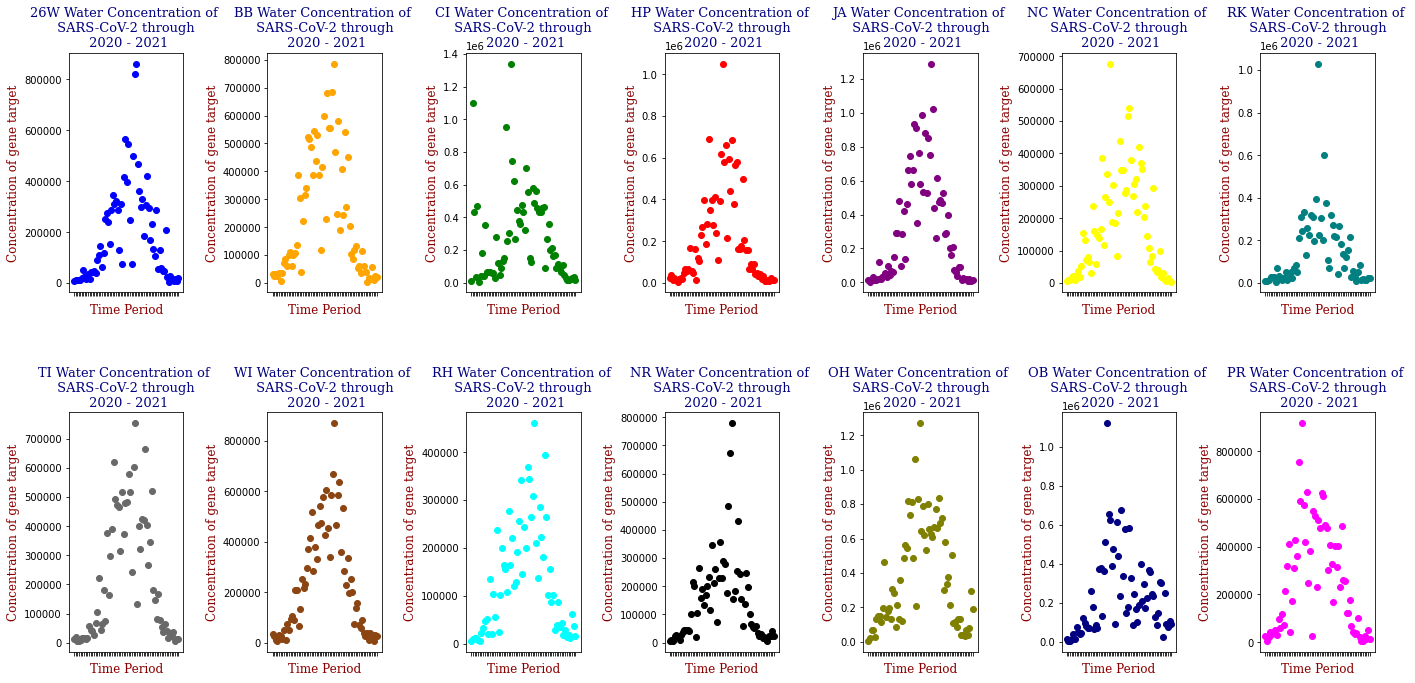

In [ ]:
create_Graphs(master_Data, "Water Concentration of \n SARS-CoV-2")

**Visualization Insight**

From our visualization, we can see that throughout the middle of the time periods (from Dec - Feb), the concentrations of the genetic material was at an all time high relative to the beginning and end months throughout all locations.

## Regression Model

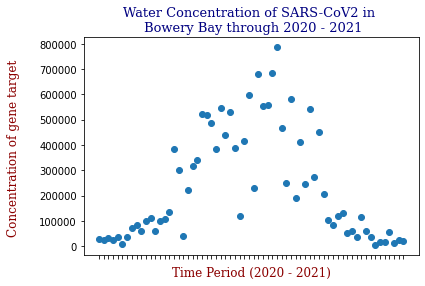

In [ ]:
# Let's take a look at our Bowery Bay graph

bb_graph()

In [ ]:
# Let's apply the model to half of the data
# First convert into a list format
bbl = bb.copies_l.values.tolist()
# Find the length
len(bbl)
# Store half the list in new variable
half_bbl = bbl[0:33]
# Check to see if you spliced correctly with len(half_bbl)

bbd = bb.test_date.values.tolist()
half_bbd = bbd[0:33]
half_bbd

['2020-09-01T00:00:00.000',
 '2020-09-09T00:00:00.000',
 '2020-09-14T00:00:00.000',
 '2020-09-16T00:00:00.000',
 '2020-09-21T00:00:00.000',
 '2020-09-23T00:00:00.000',
 '2020-09-28T00:00:00.000',
 '2020-10-07T00:00:00.000',
 '2020-10-12T00:00:00.000',
 '2020-10-14T00:00:00.000',
 '2020-10-19T00:00:00.000',
 '2020-10-21T00:00:00.000',
 '2020-10-26T00:00:00.000',
 '2020-10-28T00:00:00.000',
 '2020-11-02T00:00:00.000',
 '2020-11-04T00:00:00.000',
 '2020-11-09T00:00:00.000',
 '2020-11-11T00:00:00.000',
 '2020-11-16T00:00:00.000',
 '2020-11-18T00:00:00.000',
 '2020-11-23T00:00:00.000',
 '2020-11-25T00:00:00.000',
 '2020-11-30T00:00:00.000',
 '2020-12-02T00:00:00.000',
 '2020-12-09T00:00:00.000',
 '2020-12-14T00:00:00.000',
 '2020-12-16T00:00:00.000',
 '2020-12-21T00:00:00.000',
 '2020-12-23T00:00:00.000',
 '2020-12-28T00:00:00.000',
 '2020-12-30T00:00:00.000',
 '2021-01-04T00:00:00.000',
 '2021-01-06T00:00:00.000']

In [ ]:
placeholder_list = np.array([i for i in range(1, 34)])

placeholder_list = placeholder_list.reshape(-1, 1)

placeholder_list

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33]])

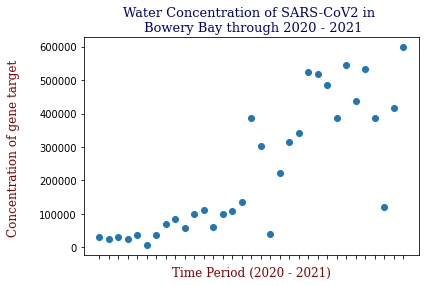

In [ ]:
def h_bbgraph():
    plt.scatter(half_bbd, half_bbl)
    plt.title("Water Concentration of SARS-CoV2 in \n Bowery Bay through 2020 - 2021", fontdict=font1)
    plt.xlabel('Time Period (2020 - 2021)', fontdict=font2), plt.ylabel('Concentration of gene target \n', fontdict=font2)
    ax = plt.gca()
    # Remove ticks & tick labels
    # ax.axes.xaxis.set_ticks([]) (depreciated method - play around with this)
    ax.axes.xaxis.set_ticklabels([])

    plt.show()

h_bbgraph()

We will use this to apply our linear regression using SCGD. We will replace the dates with a placeholder list (1 -> 33) in order to apply Stochastic Gradient Descent

In [ ]:
# Between Huber Loss, epsilon insensitive & MSE, MSE has the best performance

SGDR = SGDRegressor(loss='squared_error',penalty=None,alpha=0.0001,max_iter=1e7, tol=1e-3, epsilon=0.1)

In [ ]:
line = SGDR.fit(placeholder_list , half_bbl, coef_init=.00025, intercept_init=10000)

In [ ]:
print(SGDR.coef_, SGDR.intercept_)

[17602.16864126] [-61739.19701084]


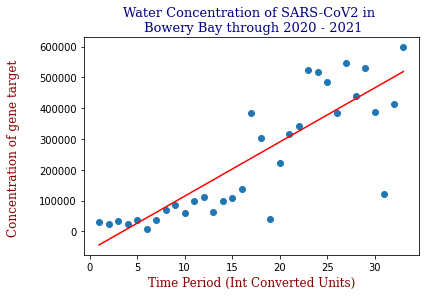

In [ ]:
y_set_to_use = [SGDR.coef_ * x + SGDR.intercept_ for x in placeholder_list]

plt.scatter(placeholder_list, half_bbl)
plt.plot(placeholder_list, y_set_to_use, color='red')
plt.title("Water Concentration of SARS-CoV2 in \n Bowery Bay through 2020 - 2021", fontdict=font1)
plt.xlabel('Time Period (Int Converted Units)', fontdict=font2), plt.ylabel('Concentration of gene target \n', fontdict=font2)

plt.show()

From this, our model is predicting that the covid concentrations in the water in Bowery Bay will steadily increase over time. Here, we can see that our prediction line is weighed heavily by the preceeding points, which interferes with the outliers as we go down the x-axis. We can adjust our model through incorporating more data points as well as changing our coefficient and intercept. 

### Conclusion
---

Our Visualization clearly shows that COVID concentrations rise during the winter months and fall during as we move away from the wintertime. As we see in our Linear Regression Model, we can see that COVID concentrations in the wastewater will continue to rise as winter draws near. Concurrently, we know that the covid rate exponentially increased over time, so we need to adjust our model to make an accurate prediction beyond a steady increase.

This method of modeling can be applied to all 14 different locations where the genetic material for SARS-CoV-2 was measured in order to create predictions of Covid concentrations throughout NYC. However as these plots are inherently not linear, linear predictive models will of course not be the best method of modeling a prediction of covid data points, unless we apply an extraordinary amount of SCGD best fit lines similarly to how we would when taking partial derivatives. In this case, we could try a Multiple Linear Regression.